# 2 Perceptron vs Neural Networks

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Question 2

### I

**Load Task2B_train.csv and Task2B_test.csv datasets, plot the training and testing data separately in two plots. Mark the data with different labels in different colors.**

In [2]:
def plot_scatter_by_label(X, y, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_figheight(6)
        fig.set_figwidth(8)
    categories = np.unique(y)
    for cat in categories:
        ax.scatter(X[y==cat, 0], X[y==cat, 1], label='Cluster {0}'.format(cat), alpha=0.8)
    ax.set_xlabel('Feature 1', size=15)
    ax.set_ylabel('Feature 2', size=15)
    ax.set_title(title if title else 'Scatter Plot by Label', size=20)
    ax.legend()
    return ax

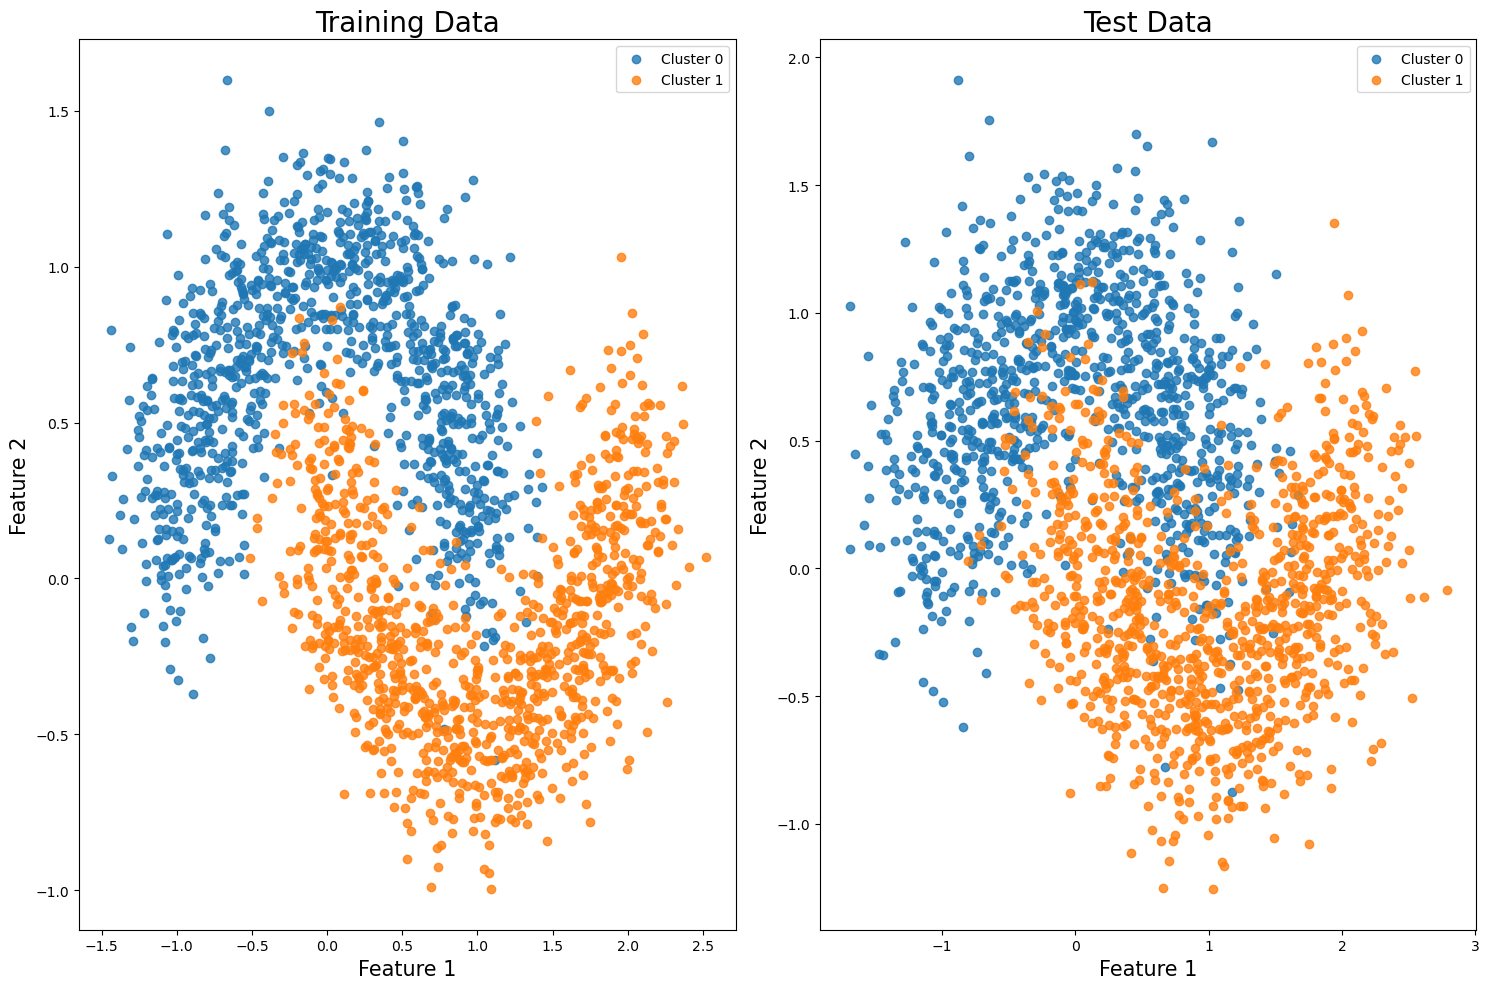

In [3]:
# Read train and test data
train_data = pd.read_csv('Task2B_train.csv')
test_data = pd.read_csv('Task2B_test.csv')

X_train = train_data[['feature1', 'feature2']].values
y_train = train_data['label'].values
X_test = test_data[['feature1', 'feature2']].values
y_test = test_data['label'].values

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

plot_scatter_by_label(X_train, y_train, ax=axes[0], title='Training Data')
plot_scatter_by_label(X_test, y_test, ax=axes[1], title='Test Data')

plt.tight_layout()
plt.show()

### II

**Train two Perceptron models on the loaded training data by setting the learning rates η to 0.1 and 1.0 respectively. Calculate the test errors of two models and find the best η and its corresponding model, then plot the decision boundary and the test data in one plot. Hint: We expect the decision boundary of your perceptron to be a linear function that separates the testing data into two parts. You may also choose to change the labels from [0, 1] to [-1, +1] for your convenience.**

In [4]:
class Perceptron:

    def __init__(self, eta=0.01, tau_max=10000, epsilon=0.005, random_state=None):
        self.eta = eta # learning rate
        self.tau_max = tau_max # max number of iterations
        self.epsilon = epsilon # tolerable error
        self.random_state = random_state # random seed

    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state) # Initialize random generator
        n, p = x.shape # Number of samples (n) and features (p)

        # Initialze iteration counter and weights 
        tau = 0
        self.w_ = RNG.normal(size=p) # Randomly initialize weights with p dimensions
        terminate = False

        # Training loop
        while not (terminate or (self.predict(x) != y).mean() < self.epsilon):
            # Randomize the order in which training points are considered
            order = RNG.choice(np.arange(n), size=n, replace=False)

            # Loop through the training points in randomized order
            for i in range(n):
                if self.predict(x[order][i]) != y[order][i]:
                    # Update weights using the Perceptron learning rule
                    # y[order][i] is 0 or 1, so (2*y[order][i]-1) converts it to -1 or 1
                    self.w_ = self.w_ + (2 * y[order][i] - 1) * self.eta * x[order][i]

                tau += 1
                # Terminate training if maximum iterations are reached
                if tau == self.tau_max:
                    terminate = True
                    break

        return self

    def predict(self, x):
        # Compute predictions using the sign of the dot product between x and w
        return (x.dot(self.w_) >= 0).astype(int) # Return 1 if dot product >= 0, otherwise 0

In [5]:
def plot_line(slope, intercept, ax=None, shape='--'):
    ax = plt.gca() if ax is None else ax
    x_vals = np.array(ax.get_xlim()) # Get the current x-axis limits
    y_vals = intercept + slope * x_vals # Compute y values based on slope and intercept
    ax.set_ylim(ax.get_ylim()) # Preserve y-axis limits
    ax.set_xlim(ax.get_xlim()) # Preserve x-axis limits
    ax.plot(x_vals, y_vals, shape, color='red')

def plot_decision_boundary_from_weights(weights, ax=None):
    # Calculate the slope and intercept from weights
    slope = -weights[0] / weights[1] # w1x1 + w2x2 = 0
    intercept = 0 # no bias, intercept is 0
    plot_line(slope, intercept, ax, shape='--') # Plot the decision boundary

In [6]:
# Different learning rates
learning_rates = [0.1, 1.0]
models = []
errors = []

for eta in learning_rates:
    model = Perceptron(eta=eta, tau_max=10000, epsilon=0.005, random_state=42)
    model.fit(X_train, y_train)
    models.append(model)

    # Calculate the test error
    error = 1 - (model.predict(X_test) == y_test).mean()
    errors.append(error)

# Find the best model (lowest test error)
best_eta_idx = np.argmin(errors)
best_eta = learning_rates[best_eta_idx]
best_model = models[best_eta_idx]

print(f'Best learning rate: {best_eta} with test error: {errors[best_eta_idx]:.2f}')

Best learning rate: 0.1 with test error: 0.16


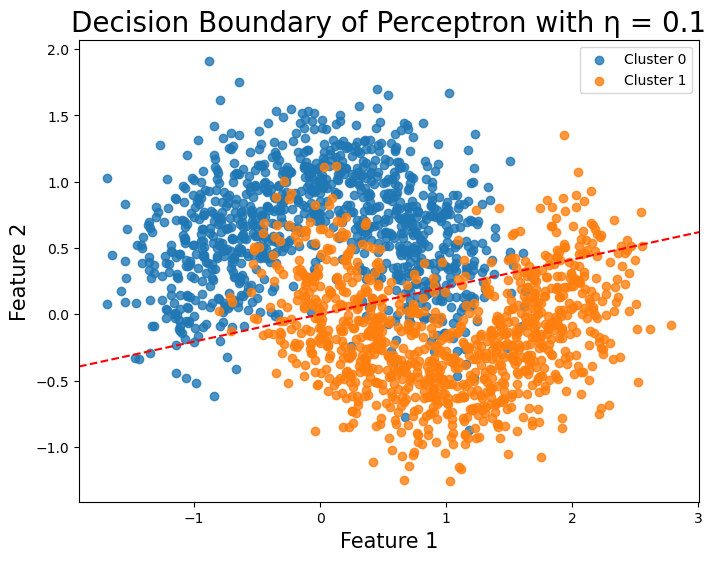

In [9]:
# Plotting the decision boundary of the best model
fig, ax = plt.subplots(figsize=(8, 6))

# Plot test data
plot_scatter_by_label(X_test, y_test, ax=ax, title=f'Decision Boundary of Perceptron with η = {best_eta}')

# Plot decision boundary
plot_decision_boundary_from_weights(best_model.w_, ax=ax)

plt.show()

### III

**For each combination of K (i.e, number of units in the hidden layer) in 5, 10, 15, ..., 40, (i.e. from 5 to 40 with a step size of 5), and η (i.e., learning rate) in 0.01, 0.001 run the 3-layer Neural Network and record testing error for each of them. Plot the effect of different K values on the accuracy of the testing data. Based on this plot, find the best combination of K and η and obtain your best model, then plot the decision boundary and the test data in one plot.**

The first step of backpropagation is to perform a feedforward pass through the network, calculating activations for each layer $(L_2, L_3, \dots, L_{n_l})$.
In the class, the feedforward method does this. It calculates:
- $z_2 = W_1 \cdot a_1 + b_1$ (the input to the hidden layer)
- $a_2 = \sigma(z_2)$ (the activation of the hidden layer)
- $z_3 = W_2 \cdot a_2 + b_2$ (the input to the output layer)
- $a_3 = \sigma(z_3)$ (the final output prediction)

The error at the output layer is computed as:
$$
\delta_i^{(n_l)} = -\left(y_i - a_i^{(n_l)}\right) \cdot f'(z_i^{(n_l)})
$$
For each layer $l$, the error term is backpropagated using the formula:
$$
\delta_i^{(l)} = \left(\sum_{j=1}^{s_{l+1}} W_{ji}^{(l)} \delta_j^{(l+1)}\right) \cdot f'(z_i^{(l)})
$$


After computing the errors $\delta$, the gradients $\nabla_{\mathbf{W}^{(l)}} J(\theta; \mathbf{x}^{(n)}, \mathbf{y}^{(n)})$ and $\nabla_{\mathbf{b}^{(l)}} J(\theta; \mathbf{x}^{(n)}, \mathbf{y}^{(n)})$ for updating the weights and biases are calculated as:
$$
\begin{align*}
\frac{\partial J(\theta; \mathbf{x}, \mathbf{y})}{\partial W_{ij}^{(l)}} &= a_j^{(l)} \delta_i^{(l+1)} \\
\frac{\partial J(\theta; \mathbf{x}, \mathbf{y})}{\partial b_i^{(l)}} &= \delta_i^{(l+1)}
\end{align*}
$$
Then we can update $\Delta \mathbf{W}^{(l)}$ and $\Delta \mathbf{b}^{(l)}$:
$$
\Delta \mathbf{W}^{(l)} := \Delta \mathbf{W}^{(l)} + \nabla_{\mathbf{W}^{(l)}} J(\theta; \mathbf{x}^{(n)}, \mathbf{y}^{(n)})
$$
$$
\Delta \mathbf{b}^{(l)} := \Delta \mathbf{b}^{(l)} + \nabla_{\mathbf{b}^{(l)}} J(\theta; \mathbf{x}^{(n)}, \mathbf{y}^{(n)})
$$

After calculating the gradients, the weights and biases are updated with gradient descent and L2 regularization:
$$
\mathbf{W}^{(l)} \leftarrow \mathbf{W}^{(l)} - \eta \left[ \left( \frac{1}{N} \Delta \mathbf{W}^{(l)} \right) + \lambda \mathbf{W}^{(l)} \right] 
$$
$$
\mathbf{b}^{(l)} \leftarrow \mathbf{b}^{(l)} - \eta \left[ \frac{1}{N} \Delta \mathbf{b}^{(l)} \right]
$$

In [8]:
class NeuralNetwork:

    def __init__(self, input_size, hidden_size, output_size, eta=0.1, lambda_=0.0001, epoch_max=500, seed=None):
        if seed is not None:
            np.random.seed(seed)

        self.input_size = input_size # Number of input features
        self.hidden_size = hidden_size # Number of neurons in the hidden layer
        self.output_size = output_size # Number of output neurons (1 for binary classification)
        self.eta = eta # Learning rate
        self.lambda_ = lambda_ # Regularization term
        self.epoch_max = epoch_max # Maximum number of training epochs

        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) 
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))

        # For tracing accuracy over epochs
        self.train_acc = []
        self.test_acc = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def accuracy(self, predictions, targets):
        return np.mean(predictions == targets)

    def feedforward(self, X):
        a1 = X # Input layer
        z2 = np.dot(a1, self.W1) + self.b1 # Hidden layer input
        a2 = self.sigmoid(z2) # Hidden layer activation
        z3 = np.dot(a2, self.W2) + self.b2 # Output layer input
        a3 = self.sigmoid(z3) # Output layer activation (prediction)
        return a1, a2, a3, z2, z3

    def backpropagation(self, T, z2, z3, a3):
        d3 = -(T - a3) * self.sigmoid_derivative(z3) # Output layer error
        d2 = np.dot(d3, self.W2.T) * self.sigmoid_derivative(z2) # Hidden layer error
        return d2, d3

    def prediction(self, X):
        _, _, a3, _, _ = self.feedforward(X)
        return np.round(a3)

    def train(self, X_train, T_train, X_test, T_test):
        N = X_train.shape[0]
        
        epoch = 1
        terminate = False

        while not terminate:
            # Feedforward
            a1, a2, a3, z2, z3 = self.feedforward(X_train)

            # Backpropagation
            d2, d3 = self.backpropagation(T_train, z2, z3, a3)

            # Weight updates with regularization
            W1_d = np.dot(a1.T, d2)
            b1_d = d2
            W2_d = np.dot(a2.T, d3)
            b2_d = d3

            # Update weights and biases
            self.W1 -= self.eta * (W1_d / N + self.lambda_ * self.W1)
            self.b1 -= self.eta * b1_d.mean(axis=0, keepdims=True)
            self.W2 -= self.eta * (W2_d / N + self.lambda_ * self.W2)
            self.b2 -= self.eta * b2_d.mean(axis=0, keepdims=True)

            # Track training and test accuracy
            self.train_acc.append(self.accuracy(self.prediction(X_train), T_train))
            self.test_acc.append(self.accuracy(self.prediction(X_test), T_test))

            # Increment epoch
            epoch += 1

            # Check termination criteria
            if epoch >= self.epoch_max:
                terminate = True

        return self

In [9]:
# Hyperparameter configurations
hidden_units = np.arange(5, 45, 5)
learning_rates = [0.01, 0.001]
test_errors = {}

# Train the model for each combination of K and eta
for K in hidden_units:
    for eta in learning_rates:
        nn = NeuralNetwork(input_size=X_train.shape[1], hidden_size=K, output_size=1, eta=eta, epoch_max=500000)
        nn.train(X_train, y_train.reshape(-1, 1), X_test, y_test.reshape(-1, 1)) # T has the shape (N, 1)
        test_errors[(K, eta)] = 1 - nn.test_acc[-1] # Test error is 1 - test accuracy
        print(f'K={K}, η={eta}, Test error={test_errors[(K, eta)]:.4f}')

K=5, η=0.01, Test error=0.1175
K=5, η=0.001, Test error=0.1390
K=10, η=0.01, Test error=0.1005
K=10, η=0.001, Test error=0.1400
K=15, η=0.01, Test error=0.0880
K=15, η=0.001, Test error=0.1400
K=20, η=0.01, Test error=0.0905
K=20, η=0.001, Test error=0.1405
K=25, η=0.01, Test error=0.1030
K=25, η=0.001, Test error=0.1430
K=30, η=0.01, Test error=0.0870
K=30, η=0.001, Test error=0.1290
K=35, η=0.01, Test error=0.0875
K=35, η=0.001, Test error=0.1385
K=40, η=0.01, Test error=0.0865
K=40, η=0.001, Test error=0.1225


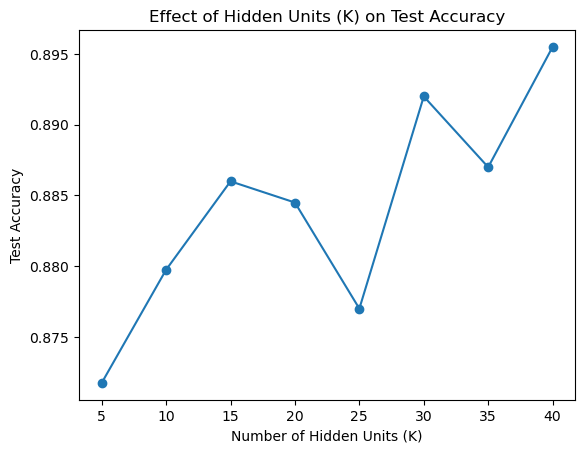

In [10]:
# Plot the effect of different K values on the test accuracy
accuracies = [np.mean([1 - test_errors[(K, eta)] for eta in learning_rates]) for K in hidden_units]
plt.plot(hidden_units, accuracies, label='Test Accuracy', marker='o')
plt.title('Effect of Hidden Units (K) on Test Accuracy')
plt.xlabel('Number of Hidden Units (K)')
plt.ylabel('Test Accuracy')
plt.show()

In [11]:
# Find the best combination of K and η
best_params = min(test_errors, key=test_errors.get)
best_K, best_eta = best_params
print(f'Best model has K={best_K} and η={best_eta} with test error {test_errors[best_params]:.4f}')

Best model has K=40 and η=0.01 with test error 0.0865


In [12]:
def plot_decision_boundary(nn, X, y, resolution=0.01):
    """
    Plots the decision boundary of a trained neural network.

    Parameters:
    nn: Trained neural network model
    X: Input data (features) for plotting the boundary
    y: True labels (used for coloring the scatter plot)
    resolution: The resolution of the grid (default is 0.01)
    """
    
    # Define the range for the plot (1 unit padding around the data)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # Range for the first feature
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # Range for the second feature
    
    # Generate a grid of points across the feature space using np.meshgrid
    # xx and yy contain the coordinates of every point in the grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # Combine the grid points into an array of shape (num_points, 2)
    # These points will be input into the neural network to make predictions
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Use the neural network to predict the labels for every point in the grid
    # The output Z will have the predicted label for each grid point
    Z = nn.prediction(grid_points)
    
    # Reshape the predictions Z to match the shape of the grid (xx.shape)
    # This allows for easy plotting of the decision boundary using contourf
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary as a filled contour plot
    # Different regions will be filled with different colors depending on the predicted class
    plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors='red')
    
    # Overlay the original data points on top of the decision boundary
    # The scatter plot will show the data points colored by their true labels
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o', alpha=0.8)
    
    # Set the x and y limits of the plot to match the grid
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    # Set the title of the plot
    plt.title("Neural Network Decision Boundary")
    
    # Display the plot
    plt.show()

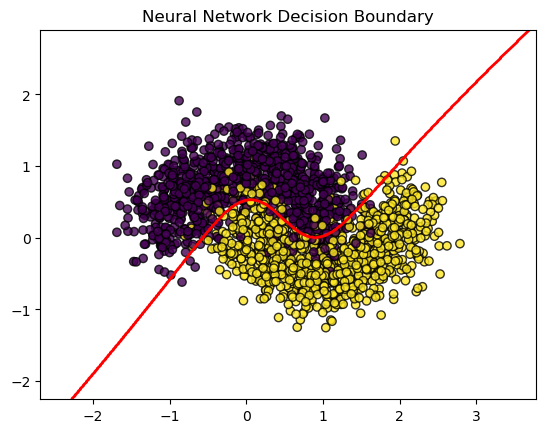

In [13]:
best_nn = NeuralNetwork(input_size=X_train.shape[1], hidden_size=best_K, output_size=1, eta=best_eta, epoch_max=500000)
best_nn.train(X_train, y_train.reshape(-1, 1), X_test, y_test.reshape(-1, 1))

plot_decision_boundary(best_nn, X_test, y_test)

### IV

**Explain the reason(s) responsible for such difference between Perceptron and a 3-layer Neural Network by comparing the plots you generated in Steps II and III. Hint: Look at the plots and think about the model assumptions.**

The difference between Perceptron and a 3-layer Neural Network:
1. Linear vs. non-linear decision boundaries
   
    The perceptron model assumes that the data is linearly separable. As a result, it generates a linear decision boundary. In this case, the boundary is a straight line that tries to divide the data into two classes. However, this assumption is too simplistic for many real-world problems, where data might not be linearly separable. In the plot, we can observe that the decision boundary is a straight line, which may not be able to fully capture the complexity of the dataset.

    A 3-layer neural network, on the other hand, is capable of learning non-linear decision boundaries due to its multiple layers and non-linear activation functions (e.g., Sigmoid). The hidden layers in the network allow it to capture more complex patterns in the data, resulting in a curved decision boundary that better separates the two classes. In the figure, the decision boundary is clearly non-linear, forming a curve that adapts to the shape of the data distribution. This allows the neural network to separate the two clusters more effectively than the perceptron.

2. Model flexibility

   A single-layer perceptron is limited to learning linear relationships between features and classes. It cannot capture more complex structures in the data because it lacks hidden layers that allow the transformation of the input space. As a result, it can only create a simple linear boundary, as seen in the figure. If the data distribution is not linearly separable, the perceptron will struggle to correctly classify the points that fall on the "wrong" side of the boundary.

    In contrast, a neural network with at least one hidden layer can learn more complex, non-linear relationships in the data. The network adjusts its wieghts across the layers to transform the input space and produce a flexible decision boundary. The curved boundary in the figure reflects the neural network's ability to model the non-linear structure in the data, making it a more powerful tool for classification tasks where the data is not linearly separable.

3. Activation functions

   The perceptron uses a hard threshold activation function, which results in a binary decision (-1 or 1) based on whether the input is above or below a certain threshold. This contributes to the linear nature of the model, limiting its flexibility.

   The neural network, however, uses non-linear activation functions (e.g., Sigmoid), which introduce non-linearity into the model. These activation functions allow the network to learn complex patterns and produce a more flexible decision boundary, as seen in the figure.